Theta  1 / 7  complete
Theta  2 / 7  complete
Theta  3 / 7  complete
Theta  4 / 7  complete
Theta  5 / 7  complete
Theta  6 / 7  complete
Theta  7 / 7  complete


c:\Users\mac\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:4411: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


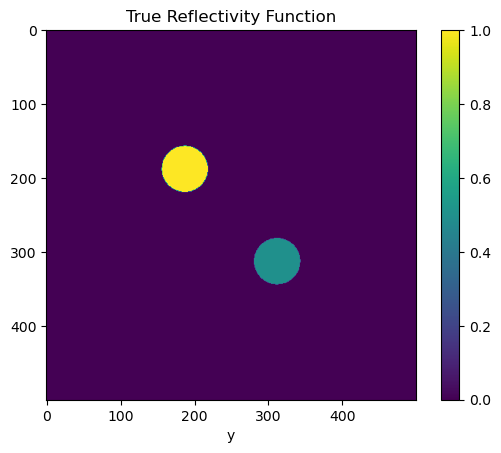

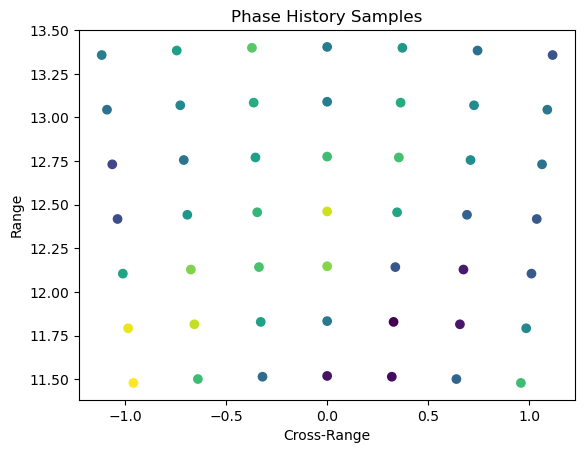

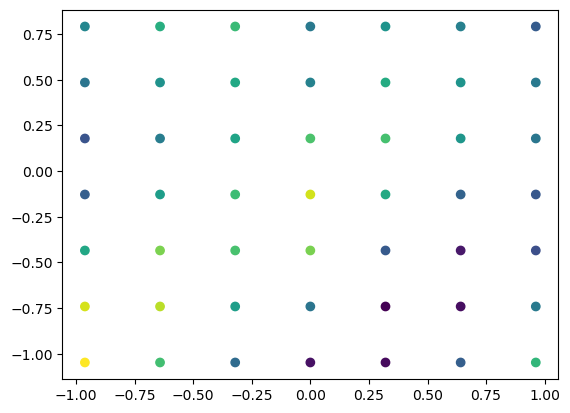

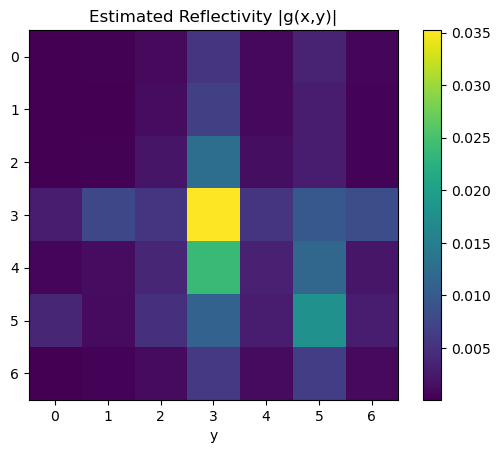

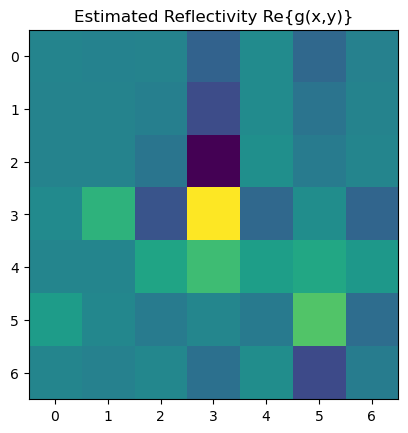

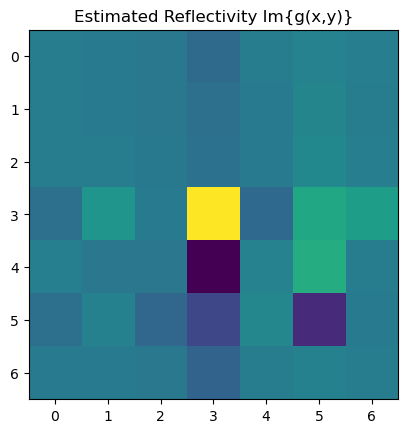

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytest

from scipy.interpolate import griddata
from typing import Callable

class sim_params:
    c = 299792458 # speed of light m/s
    
    def __init__(self, chirp_A, f0, T, R, range_res, xrange_res, patch_radius, patch_center_coords):
        self.chirp_A = chirp_A # amplitude of linear FM chirp
        self.f0 = f0 # center frequency of linear FM chirp
        self.T = T # length of linear FM chirp signal
        self.R = R # distance from radar to center of illuminated patch 
        self.range_res = range_res
        self.xrange_res = xrange_res
        self.patch_radius = patch_radius
        self.patch_center_coords = patch_center_coords
        self.omega0 = 2*np.pi*f0
        self.Bc = self.c / (2 * range_res)
        self.alpha = np.pi * self.Bc / T
        self.min_dt = self.range_res * self.T / (2 * self.patch_radius)
        self.min_dY = np.pi / self.patch_radius
        self.min_dtheta = self.c/(2*self.f0*self.xrange_res)
        self.min_dX = 4*np.pi*self.f0*self.min_dtheta/self.c

def numerically_integrate(x_min: float, x_max: float, num_terms: int, kernel: Callable):
    dx = (x_max-x_min)/num_terms
    xs = np.linspace(x_min+dx/2, x_max-dx/2, num_terms)
    integral = 0.0
    for x_idx in range(num_terms):
        integral += dx*kernel(xs[x_idx])
    return(integral)

def compute_projection_func(y: float, 
                            x_min: float, 
                            x_max: float, 
                            reflectivity_func: Callable, 
                            num_integral_terms: int) -> float:
    kernel = lambda x : reflectivity_func(x, y)
    integral = numerically_integrate(x_min, x_max, num_integral_terms, kernel)
    return(integral)

def compute_processed_return(t: float, 
                             y_min: float, 
                             y_max: float, 
                             projection_func: Callable, 
                             params: sim_params, 
                             num_integral_terms: int) -> complex:
    Y = 2/params.c*(params.omega0+2*params.alpha*(t-2*params.R/params.c))
    kernel = lambda y : projection_func(y) * np.exp(-1j*y*Y)
    processed_return = params.chirp_A/2 * numerically_integrate(y_min, y_max, num_integral_terms, kernel)
    return(processed_return)

def reflectivity_circ_rect(x, y, radius, x_shift=0, y_shift=0):
    return(1 if np.sqrt((x-x_shift)**2+(y-y_shift)**2) < radius else 0)

def plot_true_reflectivity(ground_reflectivity_func: Callable):
    nx, ny = 500, 500
    xs = np.linspace(-params.patch_radius,params.patch_radius,nx)
    ys = np.linspace(-params.patch_radius,params.patch_radius,ny)
    reflectivity_true = np.empty((nx,ny))
    for ix in range(nx):
        for iy in range(ny):
            reflectivity_true[ix,iy] = ground_reflectivity_func(xs[ix], ys[iy])
            
    plt.figure()    
    plt.imshow(np.rot90(reflectivity_true)) # need to rotate so x is horizontal
    plt.title("True Reflectivity Function")
    plt.xlabel('x')
    plt.xlabel('y')
    plt.colorbar()

if __name__ == "__main__":

    # Define simulation parameters
    params = sim_params(chirp_A = 1, 
                         f0 = 299792458, #Hz 
                         T = 1e-6, # seconds 
                         R = 1000, # meters 
                         range_res = 3.0, # meters
                         xrange_res = 3.0, # meters
                         patch_radius = 10, # meters 
                         patch_center_coords = [0.0, 0.0, 0.0]) # meters

    num_integral_terms_x = 100
    # may need to account for travel to time from edges of patch    
    start_time = 2 * params.R / params.c - params.T/2
    end_time = start_time + params.T
    sample_times = np.arange(start_time, end_time, params.min_dt) 
    num_time_samples = sample_times.size
    num_theta_samples = num_time_samples # same as num of time samples
    sample_thetas = np.linspace(-params.min_dtheta/2, params.min_dtheta/2, num_theta_samples)
    
    # compute required number of samples along y to avoid aliasing
    Ymax = 2/params.c*(params.omega0+2*params.alpha*(sample_times[-1]-2*params.R/params.c))
    num_integral_terms_y = int(np.ceil(4*Ymax*params.patch_radius)*1.5)
    # num_integral_terms_x = num_integral_terms_y
    reflective_radius = params.patch_radius / 8
    
    # define the ground reflectivity
    def ground_reflectivity1(x, y):
        return(reflectivity_circ_rect(x, y, 2*reflective_radius, 0, 0))
    def ground_reflectivity2(x, y):
        return(reflectivity_circ_rect(x, y, reflective_radius, 5, 5) + reflectivity_circ_rect(x, y, 2*reflective_radius, -5, 0))
    def ground_reflectivity3(x, y):
        return(reflectivity_circ_rect(x, y, reflective_radius, -2.5, 2.5) + 0.5*reflectivity_circ_rect(x, y, reflective_radius, 2.5, -2.5))
    def ground_reflectivity_inverse(x, y):
        return(reflectivity_circ_rect(x, y, 0.75, 0, 2.0) + reflectivity_circ_rect(x, y, 0.75, 0, -2))
    
    plot_true_reflectivity(ground_reflectivity3)
    
    # Compute the deramped radar return signal for each measurement location
    processed_returns = np.empty((num_theta_samples, num_time_samples), dtype=np.complex64())
    for theta_idx in range(num_theta_samples):
        # At each theta, I am working with a coordinate system local to the radar in which its local x value is zero
        # I call this local coordinate system x_rot, y_rot as in "rotated" and have to convert to global coordinates
        # at different places in the code as opposed to local rotated coordinates.
        theta = -sample_thetas[theta_idx] # need to use negative of theta in computing non-rotated coords
        def reflectivity_func(x_rot, y_rot):
            """ redfining reflectivity function to accept the rotated x,y coords based on radar location """
            x_global = x_rot*np.cos(theta) - y_rot*np.sin(theta)
            y_global = x_rot*np.sin(theta) + y_rot*np.cos(theta)
            return(ground_reflectivity3(x_global, y_global))
        def projection_func(y_rot):
            """ Wrapping up compute_projection_func with reflectivity_func to hand off
                to compute_processed_return """
            x_rot_bound = np.sqrt(params.patch_radius**2 - y_rot**2)
            x_rot_min, x_rot_max = -1*x_rot_bound, x_rot_bound
            num_terms = int(num_integral_terms_x * x_rot_bound / params.patch_radius) #this will ensure I have approximately uniformly spaced samples as y changes
            return(compute_projection_func(y_rot, x_rot_min, x_rot_max, reflectivity_func, num_terms))
        
        for t_idx in range(sample_times.size):
            processed_returns[theta_idx, t_idx] = compute_processed_return(sample_times[t_idx], 
                                                            -params.patch_radius, 
                                                            params.patch_radius, 
                                                            projection_func,
                                                            params,
                                                            num_integral_terms_y)
        print("Theta ",theta_idx+1,"/",num_theta_samples, " complete")
        
    # Now I need to inverse Fourier transform the data. This first requires
    # calculating the locations of each data point in X and Y
    phase_history_Xs = np.empty((num_theta_samples, num_time_samples))
    phase_history_Ys = np.empty((num_theta_samples, num_time_samples))
    for time_idx in range(num_time_samples):
        Y_rot = 2/params.c*(params.omega0+2*params.alpha*(sample_times[time_idx]-2*params.R/params.c))
        for theta_idx in range(num_theta_samples):
            theta = sample_thetas[theta_idx]
            phase_history_Xs[theta_idx, time_idx] = Y_rot * np.sin(theta)
            phase_history_Ys[theta_idx, time_idx] = Y_rot * np.cos(theta)
    #Plot polar fomatted phase history samples
    plt.figure() 
    plt.scatter(phase_history_Xs, phase_history_Ys, c=processed_returns)
    plt.title("Phase History Samples")
    plt.ylabel("Range")
    plt.xlabel("Cross-Range")
    
    # Compute bounds for the region to interpolate the phase history samples in
    # These bounds must be entirely within the space region spanned by the polar
    # raster of samples. If not, extrapolation is required and scipy doesnt like
    # that so we do lose some information here
    Y_max = Ymax * np.cos(sample_thetas[0])
    Y_min = 2/params.c*(params.omega0+2*params.alpha*(sample_times[0]-2*params.R/params.c))
    X_min = Y_min * np.tan(sample_thetas[0])
    
    # perform interpolation and plot interpolated samples
    Xs_1D = np.reshape(phase_history_Xs, (num_theta_samples*num_time_samples))
    Ys_1D = np.reshape(phase_history_Ys, (num_theta_samples*num_time_samples))
    returns_1D = np.reshape(processed_returns, (num_theta_samples*num_time_samples))
    new_Ys = np.linspace(Y_max,Y_min,int(num_theta_samples))
    new_Xs = np.linspace(X_min,-1*X_min,int(num_time_samples))
    grid_Xs, grid_Ys = np.meshgrid(new_Xs, new_Ys)
    interp_returns_real = griddata((Xs_1D, Ys_1D), np.real(returns_1D), (grid_Xs, grid_Ys), method='cubic')
    interp_returns_imag = griddata((Xs_1D, Ys_1D), np.imag(returns_1D), (grid_Xs, grid_Ys), method='cubic')
    interp_returns = interp_returns_real + 1j * interp_returns_imag
    plt.figure()
    plt.scatter(grid_Xs, grid_Ys-4*np.pi, c=interp_returns_real)
    
    # compute FFT to estimate ground reflectivity and plot it
    interp_returns = interp_returns_real + 1j * interp_returns_imag
    reflectivity_est = np.fft.ifftshift(np.fft.ifft2(interp_returns))
    plt.figure()
    plt.imshow(np.abs(reflectivity_est))
    plt.title("Estimated Reflectivity |g(x,y)|")
    plt.xlabel('x')
    plt.xlabel('y')
    plt.colorbar()
    plt.figure()
    plt.imshow(np.real(reflectivity_est))
    plt.title("Estimated Reflectivity Re{g(x,y)}")
    plt.figure()
    plt.imshow(np.imag(reflectivity_est))
    plt.title("Estimated Reflectivity Im{g(x,y)}")

    
    